# Text-Generation

Transformer language models has an uncanny feature of generating text that is almost indistinguishable from human text. This text generation happens without any explicit supervised leraning, just by predicting the next word based on context in a millions of web pages. With just pretraining LLM's learn a special set of skills and pattern recognition abilites that can be activated with different kind of prompts.

![pretraining-sequence-of-tasks](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/5-text-generation/pretraining-model-sequence-of-tasks.png?raw=1)

The image shows addition, unscramling, translation are some of the sequence tasks that an LLM is exposed during training. This knowledge is transferred during fine-tuning(for larger models during inference-time). These tasks are not chosen specifically ahead of time and occur naturally with huge corpora.

With the advent of GPT-4 and now an open sourced LLAMA2, has given rise to lot's of applications with LLM's at its core with text generation capacity.

In [5-text-generation.ipynb](../notebooks/5-text-generation.ipynb) notebook we'
ll cover how text generation works with LLM's and how different decoding stratergies impact text generation.

In [1]:
!pip install accelerate==0.21.0 transformers==4.31.0 datasets==2.14.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00


## The Challenge with Generating coherente Text

Until now in the series of notebook, we used a body and a fine-tuned head to get logits. Then we use argmax on logits to get a predicted class or softmax to get prediction probabalites for each token. By contrast, converting the model's probablistic output to text requries a *decoding method*, which introduces a few challenges unique to text generation:

* The decoding is done *iteratively* and requires more compure, not like passing the inputs through forward pass just once.
* The *quality* and *diversity* of text generated depends on the decoding method and associated hyperparameters.

To understand how this decoding process works, let's start by examining how GPT-2 is pretrained and subsequently applied to genreate text.

Like other *autoregressive* or *casual language models* GPT-2 is pretrained to estimate the probabality p(X|Y) of a sequence of tokens **y** = y1, y2,...yt, given some initial context **x** = x1, x2,...xt. Since it's impossible to acquire enough training data, the chain rule of proabality is used to factorize it as a product of *conditional probabalities*.

*Predicting token c given a and b are before it is the conditional probablity intutition*.

![alt contitional-proabablity](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/5-text-generation/llm-product-of-conditional-probabalities.png?raw=1)

The note above describe exactly the probablity calculation on right side. This pretraining objective is quite different from BERT's, which utilizer both past and furture contexts to predict a masked token.

We can generate a text by predicting next token, adding it to the sequence and use this as new sequenct to predict next token and continue this iterative process until a special end of sequence token.

Example of this process below,
![text-generation](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/5-text-generation/text-generation.png?raw=1)

> **Note:** Since the output sequence is *conditioned* on the choice of input prompt, this type of text genreation is often called as *conditional text generation*.

At the heart of this process lies the decoding method that determines which token is selected at each time step.

A language model produces a logit for each word in  the vocabulary at each time step, we can get the probabality distribution for each token using softmax.

![next-token-softmax](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/5-text-generation/next-token-softmax.png?raw=1)

The goal of most decoding methods is to search for the most likelt overall sequence by picking a y_hat such that:

![next-token-softmax](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/5-text-generation/next-token-argmax.png?raw=1)


Finding y_hat directly involve evaluating every possible sequence with the language model. Since there does not exist an algorithm to do this within an reasonable amount of time we use approximation instead. In this note, we'll explore few of these approximation methods and gradullay build up toward smarter and more complex algorithms that can gernerate high quality texts.

## Greedy Search Decoding

The simplest decoding method to get discrete tokens from a model's continuous output is to greedily select the token with the highest probabality at each timestep.

*Greedy search decoding argmax*
![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/5-text-generation/greedy-search-decoding.png?raw=1)

To see how greedy search works, let's load a 1.5 billion-parameter version of GPT-2 with a language modelling head.

In [2]:
from accelerate import init_empty_weights
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

Now let's generate some text! Although Transformers provides a generate() function for autoregressive models like GPT-2, we'll implement this decoding method to understand what's going on under the hood.

In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import torch
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
# List to store dicts of input context and next top 5 probabale tokens
iterations = []
# Number of steps to generate tokens
n_steps = 8
# Number of choices
choices_per_step = 5

with torch.no_grad():
  # Loop to generate tokens for n_steps
  for _ in range(n_steps):
    iteration = dict()
    iteration["Input"] = tokenizer.decode(input_ids[0])

    # Get model outputs
    outputs = model(input_ids=input_ids)

    # Logits --> probs -->
    next_token_logits = outputs.logits[0, -1, :] # Get logits for last token(-1) in the first batch(0)
    next_token_probs = torch.softmax(next_token_logits, dim=-1)
    sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

    for choice_idx in range(choices_per_step):
      token_id = sorted_ids[choice_idx]
      token_prob = next_token_probs[token_id].cpu().numpy()
      token_choice = {
          f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
      }
      iteration[f"Choice {choice_idx}"] = token_choice

    input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
    iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 0,Choice 1,Choice 2,Choice 3,Choice 4
0,Transformers are the,{ most (8.37%)},{ only (3.35%)},{ best (2.75%)},{ first (2.54%)},{ ultimate (2.20%)}
1,Transformers are the most,{ powerful (20.77%)},{ common (7.09%)},{ popular (5.09%)},{ important (3.29%)},{ advanced (2.72%)}
2,Transformers are the most powerful,{ beings (9.43%)},{ and (8.35%)},{ of (4.61%)},{ Transformers (4.34%)},"{, (3.83%)}"
3,Transformers are the most powerful beings,{ in (56.16%)},{ on (18.99%)},{ known (3.12%)},{ of (3.09%)},{ to (2.18%)}
4,Transformers are the most powerful beings in,{ the (72.89%)},{ existence (11.20%)},{ all (3.40%)},{ creation (1.81%)},{ Transformers (1.18%)}
5,Transformers are the most powerful beings in the,{ universe (67.94%)},{ Universe (5.41%)},{ Marvel (4.40%)},{ Transformers (3.49%)},{ mult (3.47%)}
6,Transformers are the most powerful beings in t...,{. (35.28%)},"{, (34.16%)}",{ and (12.94%)},{; (1.55%)},{! (1.34%)}
7,Transformers are the most powerful beings in t...,{ They (32.09%)},{\n (4.97%)},{ Their (4.93%)},{ The (3.85%)},{ But (2.88%)}


With this simple method we were able to generate the sentence "Transformers are the most powerful beings in the universe". Interestingly this indicates that GPT-2 has internalized some knowledge about the media franchise, which was created by two companies(Hasbro and Takara Tony).

We can also see other possible continuations at each step, highlighting the iterative nature of text generation. Unlike in sequence classification tasks where a single forward pass suffices to generate the predictrions, with text generation we need to decode the output tokens one at a time.

Let's try out the transformers `generate()` function to explore more sophisticated decoding startegies.

In [5]:
input_tokens = tokenizer(
    input_txt,
    return_tensors="pt"
)["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers are the most powerful beings in the universe. They are the creators of the universe, and


Alright, let's try out the OpenAI's unicrorn story. We'll encode the prompt using tokenizer and increase the `max_legth` to generate a longer text.

In [105]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(
    input_txt,
    return_tensors="pt"
)["input_ids"].to(device)
output_greedy = model.generate(
    input_ids, # Input encoded ids from tokens
    max_new_tokens=max_length, # Number of tokens to generate
    do_sample=False
)
output_greedy.shape

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([1, 175])

In [32]:
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, led by Dr. David M. Koehler, a professor of anthropology at the University of Colorado, Boulder, discovered the unicorns in the remote valley of La Paz, in the Andes Mountains.


"We were surprised to find that the unicorns spoke perfect English," said Koehler. "They were very friendly and friendly with us. They were very friendly with us and we were very friendly with them."


The researchers were able to identify the unicorns by their distinctive pattern of white spots on their backs. The researchers also found that the unicorns were able to communicate with each other.


We see a repeat in sequences, *They were very friendly with us* and *The researchers* were repeated twice. This is because how greedy search works.

It selects the token based on the highest probabality token withut considering the sequence. To generate good sequences it'll be better to select tokens based on the overall sequence probabality.

Greedy search decoding is not preferred to generate diverse text but it's useful for where a deterministic and factually correct output is required like arithmetic use cases

In [76]:
# Text generation for arithmetic use case using greedy searc
max_lengthx = 5
input_textx = """
5 + 8 => 13 \
7 + 1 => 8 \
1 + 1 =>
"""
input_idsx = tokenizer(
    input_textx,
    return_tensors="pt",
)["input_ids"].to(device)
output = model.generate(
    input_idsx,
    max_length=max_lengthx,
    do_sample=False,
)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 16, but `max_length` is set to 5. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.



5 + 8 => 13 7 + 1 => 8 1 + 1 =>




The generation worked correctly in gpt-large checkpoint, not loading and testing it out here due to colab memory constraints.

## Beam Search Decoding

Instead of decoding with the next highest probable token, beam search decoding keeps track of the *top-b* most probable next tokens, where *b* is refrred to as *number of beam* or *partial hypotheses. Then the next set of beams will be chose based on the current beams. This process is repeated until eos token or max_length. Finally the sequence is selected based on ranking the *b* beams accordig to log probabalities or the beam path of a sequence with highest probabality.

![beam-search-decoding-with-two-beams](../notes/images/5-text-generation/beam-search-with-two-beams.png)

*How are the sequences scored?*

We'll score the sequences using log probabaites instead of probabality itself. Because calculating the probablity of a sequence requires product of condition probabalites which is between [0,1].

Assume we've 1024 tokens with 0.5 conditional probablity the product will be so small that the computer won't be able to represent the result and cause underflow. This extremeley small number also leads to numerical unstability with the underflow. We can avoid this by applying a log on top of conditional probabalites before the product and sum of all of them. This'll reduce the risk of running into numerical unstability.

In [34]:
import numpy as np
# Without log ranking a sequence
0.5 ** 1024

5.562684646268003e-309

In [35]:
# With log
np.log(0.5) ** 1024

1.0122134649886695e-163

In [36]:
np.sum(
    [np.log(0.5)] * 1024
)

-709.782712893384

This aproach works for much smaller numbers as well. Since we need to compare the relative probabalities, we can do this directly with log probabalities.

## calculating log probabalities of sequences

Let's calculate and compare the log probabalities of the texts generated by greedy and beam search to see if beam search can improve the overall probabality.

Input tokens --> transformers models --> Unnormalized logits for the next token.

First we've to nromalize the logits to create a probabality distribution over the whole vocabulary for each token in the sequence. Then select only the token probabalities that were present in the sequence. The following functions implement the logic.

> Why probabaility over entire vocabulary for logits from sequence alone? Think of it like this, the next token can be any word from the vocabulary right? so taking the probabality over all the possible token is the correct approach to get the correct probabality for tokens in sequence.

In [46]:
# Function to calculate log probabality for a single token
import torch.nn.functional as F
def log_probs_from_logits(logits, labels):
  """
  Function to get log probabality for a single token
  """
  # [1, 175, 50257] --> [1, 175]
  logp = F.log_softmax(logits, dim=-1)
  logp_label = torch.gather(
      logp, # Logits
      2, # Dimension to gather tensors,
      labels.unsqueeze(2), # Tensor indexes to gather
  ).squeeze(-1)
  return logp_label

In [80]:
# Let's break down these to understand the shapes
print(f"Input to model shape: {output_greedy.shape}")
op = model(output_greedy)
print(f"Logits shape: {op.logits.shape}")

Input to model shape: torch.Size([1, 175])
Logits shape: torch.Size([1, 175, 50257])


We've an logits of shape 50257(vocab size) for each token of the input.

In [83]:
# We'll ignore the last token logit as we don't have truth label
# We don't use the logit for the first label
op_x = op.logits[:, :-1, :]
print(f"Shape of logits after removing last logit: {op_x.shape}")
label_x = output_greedy[:, 1:]
print(f"Shape of label after leaving out first label: {label_x.shape}")

Shape of logits after removing last logit: torch.Size([1, 174, 50257])
Shape of label after leaving out first label: torch.Size([1, 174])


In [88]:
# what did we leave out
output_greedy[0, 0],output_greedy[0, 1]

(tensor(818), tensor(257))

In [89]:
# Next we gather the probabalities based on labels from logits softmax
op_softmax = F.log_softmax(op_x, dim=-1)
print(f"log softmax shape: {op_softmax.shape}")

log softmax shape: torch.Size([1, 174, 50257])


In [91]:
# To get the indexes to match logits shape, we unsqueeze the labels at 2nd dimension
label_2_dim_stretched = label_x.unsqueeze(2)
print(f"Shape of unsqueeze label: {label_2_dim_stretched.shape}")

Shape of unsqueeze label: torch.Size([1, 174, 1])


In [94]:
label_2_dim_stretched[0, 0, 0], torch.tensor([[[257]]]).shape

(tensor(257), torch.Size([1, 1, 1]))

In [97]:
# Cherry picking the log probabality of a single token in the sequence
op_softmax[0, 0, 257]
# This will be the value at 0th index

tensor(-2.7840, grad_fn=<SelectBackward0>)

In [98]:
logp_label = log_probs_from_logits(
    op_x,
    label_x
)

In [101]:
# Same output as manual process
logp_label[0, 0]

tensor(-2.7840, grad_fn=<SelectBackward0>)

What we do in `log_probs_from_logits()` in this function is stretch the truth labels and pick the log softmax probablity of the model output for these inputs.

We also perform an alignment of logits and labels before passing them as inputs to this function:
* Since the model preidcts the next token, we do not get a logit for the first label as this is the beginning of the sequence and no token to predict this.
* We don't use the last logit because, it's a prediction and we don't have the truth label for it.

We can use the above function to collect log probabalites of a sequence by getting log probabality for each token and sum them together.

In [24]:
def sequence_logprob(model, labels, input_len=0):
  with torch.no_grad():
    output = model(labels)
    log_probs = log_probs_from_logits(
        output.logits[:, :-1 :],
        labels[:, 1:],
    )
    seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy( )

### Sequence log probabality of greedy log decoder

In [103]:
logp = sequence_logprob(
    model,
    output_greedy,
    input_len=len(input_ids[0])
)
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, led by Dr. David M. Koehler, a professor of anthropology at the University of Colorado, Boulder, discovered the unicorns in the remote valley of La Paz, in the Andes Mountains.


"We were surprised to find that the unicorns spoke perfect English," said Koehler. "They were very friendly and friendly with us. They were very friendly with us and we were very friendly with them."


The researchers were able to identify the unicorns by their distinctive pattern of white spots on their backs. The researchers also found that the unicorns were able to communicate with each other.

log-prob: -161.98


Next let's generate a beam search sequence and compare it with the greedy  decoding log prob score.

How do we generate beam search output? We can do this with `generate()` and passing it a parameter `num_beams`. num_beams is directly proportional to the increase in compute and time taken to generate the text and it's increase in text quality.

In [107]:
input_txt, input_ids

('In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\n\n',
 tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
          28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
          19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
           6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
          19942,  5158,  2818,  3594,    13,   628,   198]]))

In [108]:
output_beam = model.generate(
  input_ids,
  max_length=max_length,
  num_beams=5,
  do_sample=False
)
logp = sequence_logprob(
    model,
    output_beam,
    input_len=len(input_ids[0])
)
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of researchers from the University of California, Santa Cruz (UCSF) and the University of Colorado, Boulder (UCL).


The unicorns were found in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The team of researchers, led by

log-prob: -61.69


We get a higher(higher is better) log probabality compared with greedy search decoding. To improve the text generation and reduce repetitive text, we can impose an n-gram penalty with the `no-repeat_ngram_size` paramter that tracks which *n-grams* have been seen and sets the next token probabality to zero if it would produce a previously seen n-gram:

In [114]:
ouput_beam = model.generate(
  input_ids,
  max_length=max_length,
  num_beams=5,
  do_sample=False,
  no_repeat_ngram_size=2,
)
logp = sequence_logprob(
    model,
    ouput_beam,
    input_len=len(input_ids[0]),
)
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of researchers from the University of California, Santa Cruz (UCSF) and the University of Colorado, Boulder (UCL).


The unicorns were found in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The team of researchers, led by

log-prob: -87.12


We've stopped the repetitions(spoke perfect english) despite getting a lower score, the text remains coherent.

* Beam search with n-gram penalty is a good way to find a trade-off between focusing on high-probabality tokens(with beam search) while reducing repitions(with n-gram penalty). This is commonly used in application such as summarization or machine translation where factual correctness is important.

* Another alternative to reduce reptitions with increase increase in text diversity and reduced factual corectness(chatbot, story generation applications) we can use sampling. We'll explore sampling next.

## Sampling Methods

The simplest sampling method is to randomly sample from the probabality distribution of the model's outputs over the full vocabulary at each timestep.

We can easily control the diversity of the output by adding a temperature parameter T that rescales the logits before taking the softmax.

By Tuning T we can control the shape of the probabality distribution. When T << 1, the distribution becomes peaked around the origin and the rare tokens are suppressed. On the other hand wher T >>1 the distribution flattens out and each token becomes equally likely. Let's observe this effect of temeperature on token probabalities next.

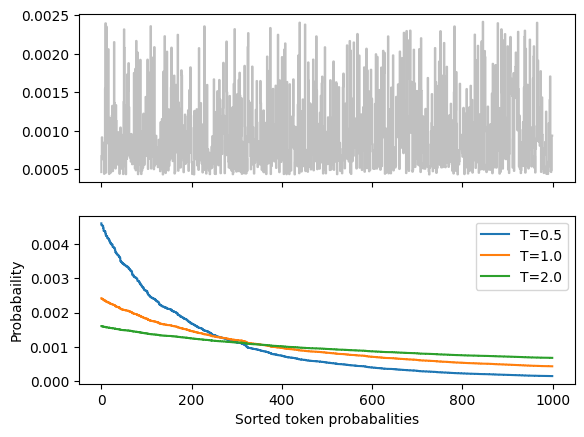

In [144]:
# Distribution of randomly generated token probabalites
import matplotlib.pyplot as plt
import numpy as np


def softmax(logits, T=1):
  e_x = np.exp(logits / T)
  return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
logits_without_t = np.exp(logits) / np.exp(logits).sum()
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.step(x, logits_without_t, label="NoT", c="silver")

for T in [0.5, 1.0, 2.0]:
  ax2.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabalities")
plt.ylabel("Probabaility")
plt.show()

Let's check how temperature influences text generation.

In [150]:
torch.manual_seed(42);

output_temp = model.generate(
  input_ids,
  max_length=max_length,
  do_sample=True,
  temperature=2.0
  )
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


To unravel this story you need several keys information—such as geographical placement as compared to the general terrain—in the context and for the context. To do your math with those you need more help—that your calculations may miss places and may cause strange or confusing calculations such as moving in too close.

So in a related news there has already been this unicorn named Lucy at a private training course by


We can see that a high temperate had produced gibberish, we've caused the model to create strange grammart and quite a few made up words. Let's see what happens if we cool down the temperature.

In [151]:
# Reduce the temperature
torch.manual_seed(42);

output_temp = model.generate(
  input_ids,
  max_length=max_length,
  do_sample=True,
  temperature=0.5,
  )
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of Colorado Boulder, discovered the unicorns in a remote valley, in the Andes Mountains, and they were so familiar with each other that they could understand each other's gestures.

"They were speaking perfect English. They were just talking in perfect English, and they weren't even talking to each other," said the lead researcher, Dr. Scott L. McBride


The text with low temperature is more coherent.

> **Note**: Main point with temperature is it allow us to control the quality of the samples, but there's always a trade-off between coherence(low temperature) and diversity(high temperature) that one has to tune to the use case at hand.

Another way to adjust the trade-off between coherence and diversity is to truncate the distribuion of the vocabulary. This allows us to adjust the diversity freely with temperature but with a limit that excludes word that would be too strange in the context(i.e low probabality words). There are two main ways to do this top-k and nucleus sampling.